Next, we apply inferential statistics techniques to explore the data and better understand the relationship between our variables.


In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats

In [169]:
reviews=pd.read_csv('/Users/anna/Downloads/reviews.csv.gz',compression='gzip').dropna()
listings=pd.read_csv('/Users/anna/Downloads/listings (1).csv',error_bad_lines=False)
neighborhoods=pd.read_csv('/Users/anna/Downloads/neighbourhoods.csv',error_bad_lines=False)
crime=pd.read_csv('/Users/anna/Downloads/crime rates.csv',error_bad_lines=False).dropna()

inactive=listings.loc[listings.availability_365==365]
inactive.set_index('id',inplace=True)
listings.set_index('id',inplace=True)
new_listings=listings.drop(inactive.index,axis=0)

autopost_1=reviews[reviews.comments.str.contains('The host canceled my reservation')]
autopost_2=reviews[reviews.comments.str.contains('This is an automated posting')]
autopost=pd.concat([autopost_1,autopost_2], axis=0).reset_index()


canceled=autopost.listing_id.value_counts()
num_cancel=canceled.to_frame(name='cancellations')
new_listings['num_cancellations']=num_cancel

booked=365-new_listings.availability_365
booked=booked.to_frame('days booked')
df=new_listings.merge(booked, how='left',left_index=True,right_index=True)
df=df[['neighbourhood','room_type','price','minimum_nights','number_of_reviews'\
       ,'calculated_host_listings_count','days booked','num_cancellations']]


def days_count(text):
    if 'the day before' in text:
        return 1
    else:
        return int(re.findall('\d+', text)[0])

total_days=pd.DataFrame(autopost.comments.apply(days_count))

auto=pd.merge(autopost,total_days,how='left',left_index=True,right_index=True)

avg_days=pd.DataFrame(auto[['listing_id','comments_y']].groupby('listing_id')['comments_y'].apply(np.mean).apply(round))

conv = lambda x: float(x.replace(',',''))
crime['Number_of_offences']=crime.Number_of_offences.apply(conv)
all_crimes=crime[crime['Offences']=='All recorded offences']

all_crimes=all_crimes[all_crimes['Borough']!='Inner London']
all_crimes=all_crimes[all_crimes['Borough']!='England and Wales']
all_crimes=all_crimes[all_crimes['Borough']!='Met Police Area']
all_crimes=all_crimes[all_crimes['Borough']!='Outer London']
all_crimes=all_crimes[all_crimes['Borough']!='Heathrow']

conv_fl = lambda x: int(x.replace('-',''))
year = all_crimes.Year.apply(conv_fl)
all_crimes['Year']=year
latest=all_crimes[(all_crimes['Year'])>=201112]
df_main=pd.merge(df,latest.groupby('Borough').mean(),left_on='neighbourhood',right_on='Borough',how='left')

**Cancellations vs Price**

Null Hypothesis: There is no significant correlation between the number of cancellations vs the price of the listing.

Alternative Hypothesis: There is a significant correlation between the two.

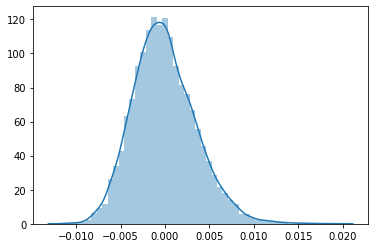

observed correlation between price and number of cancellations: -0.02526
p-value: 0.0000000000
We reject the null. There is a significant correlation between price and number of cancellations


In [205]:
price=pd.DataFrame(df[df.price!=0]['price'])
cancel=pd.DataFrame(df.num_cancellations.fillna(0))
price_cancel = price.merge(cancel,how='left',left_index=True,right_index=True)

#actual correlation between the two
c1=stats.pearsonr(price_cancel.price,price_cancel.num_cancellations)[0]


#bootstrapping

corr_replicates=np.empty(10000)

for i in range(10000):
    price_perm=np.random.permutation(price_cancel.price)
    corr_replicates[i]=stats.pearsonr(price_perm,price_cancel.num_cancellations)[0]

_=sns.distplot(corr_replicates)
plt.show()


p1 = (np.sum(np.abs(corr_replicates)>=np.abs(c1))/10000)

print('observed correlation between price and number of cancellations: %.5f'%c1)
print('p-value: %.10f' % p1)

if p1>0.01:
    print('We fail to reject the null. There is no significant correlation between price and number of cancellations')
else:
    print('We reject the null. There is a significant correlation between price and number of cancellations')



**Cancellations vs Popularity (Number of Reviews)**

Null Hypothesis: There is no significant correlation between the number of cancellations vs the number of reviews a listing gets.

Alternative Hypothesis: There is a significant correlation between the two.

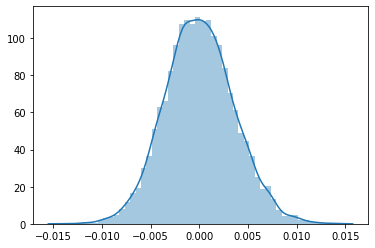

observed correlation between price and number of reviews: 0.21254
p-value: 0.0000000000
We reject the null. There is a significant correlation between between the number of cancellations and number of reviews


In [207]:
#actual correlation between the two
c2=stats.pearsonr(df.number_of_reviews,cancel.num_cancellations)[0]


#bootstrapping

corr_replicates=np.empty(10000)

for i in range(10000):
    rev_perm=np.random.permutation(df.number_of_reviews)
    corr_replicates[i]=stats.pearsonr(rev_perm,cancel.num_cancellations)[0]

_=sns.distplot(corr_replicates)
plt.show()


p2 = (np.sum(np.abs(corr_replicates)>=np.abs(c2))/10000)

print('observed correlation between price and number of reviews: %.5f'%c2)
print('p-value: %.10f' % p2)

if p2>0.01:
    print('We fail to reject the null. There is no significant correlation between the number of cancellations and number of reviews')
else:
    print('We reject the null. There is a significant correlation between between the number of cancellations and number of reviews')
    

**Cancellations vs Demand(Days Booked)**

Null Hypothesis: There is no significant correlation between the number of cancellations and the number of days the listing is booked.

Alternative Hypothesis: There is a significant correlation between the two.

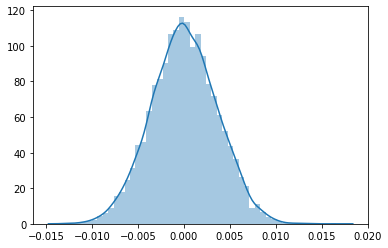

observed correlation between number of days booked and number of cancellations: -0.01100
p-value: 0.0018000000
We reject the null. There is a significant correlation between the number of cancellations and the number of days the listing is booked.


In [210]:
#actual correlation between the two
c3=stats.pearsonr(df['days booked'],cancel.num_cancellations)[0]


#bootstrapping

corr_replicates=np.empty(10000)

for i in range(10000):
    days_perm=np.random.permutation(df['days booked'])
    corr_replicates[i]=stats.pearsonr(days_perm,cancel.num_cancellations)[0]

_=sns.distplot(corr_replicates)
plt.show()


p3 = (np.sum(np.abs(corr_replicates)>=np.abs(c3))/10000)

print('observed correlation between number of days booked and number of cancellations: %.5f'%c3)
print('p-value: %.10f' % p3)

if p3>0.05:
    print('We fail to reject the null. There is no significant correlation  between the number of cancellations and the number of days the listing is booked.')
else:
    print('We reject the null. There is a significant correlation between the number of cancellations and the number of days the listing is booked.')
    


**Cancellation vs Minimum Nights**

Null Hypothesis: There is no significant correlation between the number of cancellations and the minimum nights required by a listing.

Alternative Hypothesis: There is a significant correlation between the two.

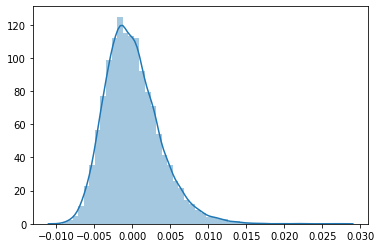

observed correlation between minimum nights and number of cancellations: -0.00473
p-value: 0.1630000000
We fail to reject the null. There is no significant correlation between the number of cancellations and the minimum nights required by a listing.


In [212]:
#actual correlation between the two
c4=stats.pearsonr(df.minimum_nights,cancel.num_cancellations)[0]


#bootstrapping

corr_replicates=np.empty(10000)

for i in range(10000):
    min_perm=np.random.permutation(df.minimum_nights)
    corr_replicates[i]=stats.pearsonr(min_perm,cancel.num_cancellations)[0]

_=sns.distplot(corr_replicates)
plt.show()


p4 = (np.sum(np.abs(corr_replicates)>=np.abs(c4))/10000)

print('observed correlation between minimum nights and number of cancellations: %.5f'%c4)
print('p-value: %.10f' % p4)

if p4>0.01:
    print('We fail to reject the null. There is no significant correlation between the number of cancellations and the minimum nights required by a listing.')
else:
    print('We reject the null. There is a significant correlation between the number of cancellations and the minimum nights required by a listing.')



**Cancellation vs Crime Rate**

Null Hypothesis: There is no significant correlation between the number of cancellations and the crime rate of the neighbourhood that the listing belongs in.

Alternative Hypothesis: There is a significant correlation between the number of cancellations and the crime rate of the neighbourhood that the listing belongs in.

In [213]:
#No crime rate info for City of London since it is not one of the offical
#boroughs of London

df_main[df_main['Rate'].isnull()==True].head()
df_main['num_cancellations']=df_main.num_cancellations.fillna(0)
crime_cancel=df_main[df_main.neighbourhood!='City of London']

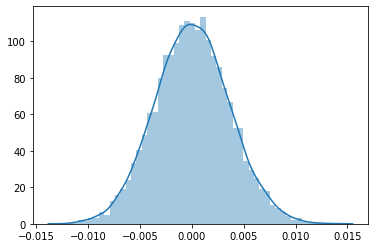

observed correlation between crime rate and number of cancellations: 0.01161
p-value: 0.0009000000
We reject the null. There is a significant correlation between the number of cancellations and the crime rate of the neighbourhood that the listing belongs in.


In [214]:
#actual correlation between the two
c5=stats.pearsonr(crime_cancel.Rate,crime_cancel.num_cancellations)[0]

#bootstrapping

corr_replicates=np.empty(10000)

for i in range(10000):
    crime_perm=np.random.permutation(crime_cancel.Rate)
    corr_replicates[i]=stats.pearsonr(crime_perm,crime_cancel.num_cancellations)[0]

_=sns.distplot(corr_replicates)
plt.show()


p5 = (np.sum(np.abs(corr_replicates)>=np.abs(c5))/10000)

print('observed correlation between crime rate and number of cancellations: %.5f'%c5)
print('p-value: %.10f' % p5)

if p5>0.01:
    print('We fail to reject the null. There is no significant correlation between the number of cancellations and the crime rate of the neighbourhood that the listing belongs in.')
else:
    print('We reject the null. There is a significant correlation between the number of cancellations and the crime rate of the neighbourhood that the listing belongs in.')


**Cancellation by Neighborhood?**

Null Hypothesis: The average number of cancellations of each neighbourhood are not statistically different from each other.

Alternative Hypothesis: The average number of cancellations of each neighbourhood are statistically different from each other.

In [172]:
neighbourhood=list(set(df.neighbourhood))
df['num_cancellations']=df.num_cancellations.fillna(0)

In [144]:
f_results=stats.f_oneway(np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[0]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[1]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[2]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[3]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[4]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[5]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[6]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[7]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[8]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[9]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[10]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[11]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[12]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[13]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[14]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[15]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[16]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[17]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[18]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[19]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[20]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[21]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[22]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[23]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[24]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[25]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[26]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[27]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[28]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[29]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[30]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[31]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[32]]))


In [153]:
print('f-stat: %.5f'%f_results[0])
print('p-value:%.10f'%f_results[1])

if f_results[1]>0.05:
    print('The average number of cancellations of each neighbourhood are not statistically different from each other.')
else:
    print('The average number of cancellations of each neighbourhood are statistically different from each other.')

f-stat: 4.65329
p-value:0.0000000000
The average number of cancellations of each neighbourhood are statistically different from each other.


**Cancellation by Room Type?**

Null Hypothesis: The average number of cancellations of each room type are not statistically different from each other.

Alternative Hypothesis: The average number of cancellations of each room type are statistically different from each other.

In [155]:
room=list(set(df.room_type))

In [158]:
f_results2=stats.f_oneway(np.array(df['num_cancellations'][df['room_type']==room[0]]),np.array(df['num_cancellations'][df['room_type']==room[1]])\
                         ,np.array(df['num_cancellations'][df['room_type']==room[2]]))

print('f-stat: %.5f'%f_results2[0])
print('p-value:%.10f'%f_results2[1])

if f_results2[1]>0.05:
    print('The average number of cancellations of each room type are not statistically different from each other.')
else:
    print('The average number of cancellations of each room type are statistically different from each other.')

f-stat: 11.68846
p-value:0.0000084047
The average number of cancellations of each room type are statistically different from each other.
